In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy 
import scipy.io as sio
from scipy.interpolate import griddata
from sklearn.metrics.pairwise import haversine_distances

%config InlineBackend.figure_format = "retina"

# Read Ozawa et al. (2011) coseismic and postseismic slip distributions

In [2]:
df_coseismic = pd.read_csv("ozawa_table1.csv")
df_coseismic["magnitude"] = np.sqrt(
    df_coseismic.ew.values**2.00 + df_coseismic.ns.values**2.00
)
df_postseismic = pd.read_csv("ozawa_table2.csv")
df_postseismic["magnitude"] = np.sqrt(
    df_postseismic.ew.values**2.00 + df_postseismic.ns.values**2.00
)


# Interpolate data onto regular grid and extract coseismic and postseismic slip along a single fault perpendicular profile

In [3]:
# Grid and interpolate the coseismic and postseismic slip distributions
lon_vec = np.linspace(139, 144, 100)
lat_vec = np.linspace(35, 42, 100)
lon_grid, lat_grid = np.meshgrid(lon_vec, lat_vec)
points = np.array([df_coseismic.longitude, df_coseismic.latitude]).T

grid_coseismic = griddata(
    points, df_coseismic.magnitude, (lon_grid, lat_grid), method="cubic"
)
grid_postseismic = griddata(
    points, df_postseismic.magnitude, (lon_grid, lat_grid), method="cubic"
)

grid_coseismic[np.isnan(grid_coseismic)] = np.nanmin(grid_coseismic)
grid_postseismic[np.isnan(grid_postseismic)] = np.nanmin(grid_postseismic)

# Extract a profile line from the coseismic and postseismic data
start_point = (60, 30)
end_point = (40, 99)
n_profile = 10000
x_extract = np.linspace(start_point[0], end_point[0], n_profile)
y_extract = np.linspace(start_point[1], end_point[1], n_profile)
coseismic_profile = scipy.ndimage.map_coordinates(
    grid_coseismic, np.vstack((x_extract, y_extract))
)
postseismic_profile = scipy.ndimage.map_coordinates(
    grid_postseismic, np.vstack((x_extract, y_extract))
)

# Postseismic / coseiseismic geometric moment ratio 

In [57]:
print(f"postseismic / coseismic = {np.sum(grid_postseismic) / np.sum(grid_coseismic) * 100:0.3}%")

postseismic / coseismic = 7.64%


# Plot slip distributions and profiles

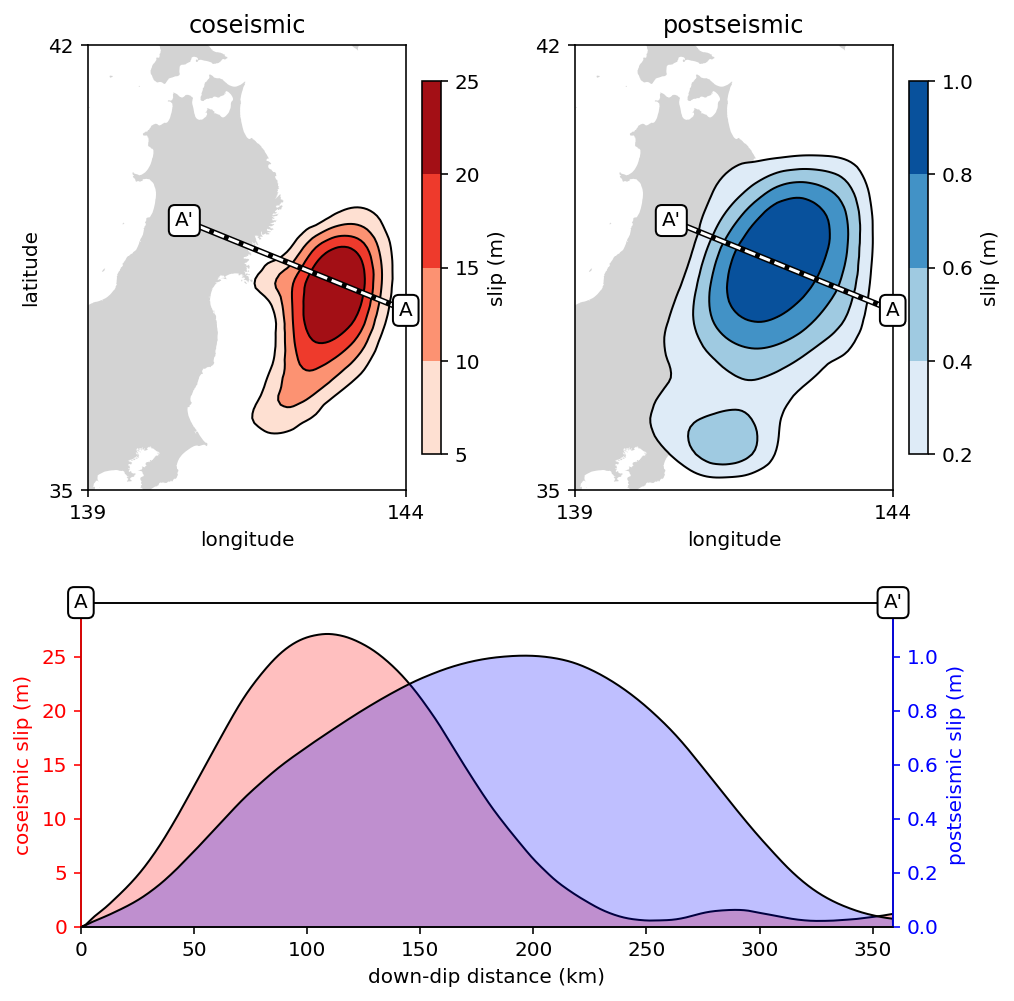

In [58]:
WORLD_BOUNDARIES = sio.loadmat("WorldHiVectors.mat")
RADIUS_EARTH = 6371
dip_approximate = np.deg2rad(18.0)
coseismic_color = "red"
postseismic_color = "blue"

end_lat_lon = np.deg2rad(
    ([lat_grid[end_point[0], end_point[1]], lon_grid[end_point[0], end_point[1]]])
)
start_lat_lon = np.deg2rad(
    [lat_grid[start_point[0], start_point[1]], lon_grid[start_point[0], start_point[1]]]
)
profile_length = (
    RADIUS_EARTH
    / np.cos(dip_approximate)
    * haversine_distances([start_lat_lon, end_lat_lon])[0, 1]
)
x_position = np.copy(x_extract)
x_position = np.linspace(0, profile_length, n_profile)
x_position = np.flipud(x_position)

# Convert x_extract and y_extract to lon_extract and lat_extract.
lon_extract = np.linspace(
    lon_grid[start_point[0], start_point[1]],
    lon_grid[end_point[0], end_point[1]],
    n_profile,
)
lat_extract = np.linspace(
    lat_grid[start_point[0], start_point[1]],
    lat_grid[end_point[0], end_point[1]],
    n_profile,
)

plt.figure(figsize=(8, 9))
plt.subplot(2, 2, 1)
plt.fill(
    WORLD_BOUNDARIES["lon"],
    WORLD_BOUNDARIES["lat"],
    color="lightgray",
    linewidth=0.0,
    edgecolor="none",
)
levels = np.array([5, 10, 15, 20, 25])
grid_coseismic_plot = np.copy(grid_coseismic)
grid_coseismic_plot[grid_coseismic_plot > 25.0] = 25.0
plt.contourf(lon_grid, lat_grid, grid_coseismic_plot, levels=levels, cmap="Reds")
plt.colorbar(extend="both", label="slip (m)", fraction=0.046, pad=0.04)
plt.contour(
    lon_grid,
    lat_grid,
    grid_coseismic_plot,
    levels=levels,
    colors="k",
    linestyles="solid",
    linewidths=1.00,
)
plt.plot(lon_extract, lat_extract, "-k", linewidth=3.0)
plt.plot(lon_extract, lat_extract, "--w", linewidth=1.5)
props = dict(boxstyle="round", facecolor="white", alpha=1.0)
plt.text(
    lon_extract[0],
    lat_extract[0],
    "A'",
    fontsize=10,
    verticalalignment="center",
    horizontalalignment="center",
    bbox=props,
)
plt.text(
    lon_extract[-1],
    lat_extract[-1],
    "A",
    fontsize=10,
    verticalalignment="center",
    horizontalalignment="center",
    bbox=props,
)

plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("coseismic")
plt.xlim([139, 144])
plt.ylim([35, 42])
plt.xticks([139, 144])
plt.yticks([35, 42])
plt.gca().set_aspect("equal", adjustable="box")

# Postseismic slip distribution
plt.subplot(2, 2, 2)
plt.fill(
    WORLD_BOUNDARIES["lon"],
    WORLD_BOUNDARIES["lat"],
    color="lightgray",
    linewidth=0.0,
    edgecolor="none",
)
levels = np.array([0.2, 0.4, 0.6, 0.8, 1.0])
grid_postseismic_plot = np.copy(grid_postseismic)
grid_postseismic_plot[grid_postseismic_plot > 1.0] = 1.0
plt.contourf(
    lon_grid,
    lat_grid,
    grid_postseismic_plot,
    levels=levels,
    cmap="Blues",
    vmin=0.2,
    vmax=1.0,
)
plt.colorbar(extend="both", label="slip (m)", fraction=0.046, pad=0.04)
plt.contour(
    lon_grid,
    lat_grid,
    grid_postseismic_plot,
    levels=levels,
    colors="k",
    linestyles="solid",
    linewidths=1.00,
)
plt.plot(lon_extract, lat_extract, "-k", linewidth=3.0)
plt.plot(lon_extract, lat_extract, "--w", linewidth=1.5)
plt.text(
    lon_extract[0],
    lat_extract[0],
    "A'",
    fontsize=10,
    verticalalignment="center",
    horizontalalignment="center",
    bbox=props,
)
plt.text(
    lon_extract[-1],
    lat_extract[-1],
    "A",
    fontsize=10,
    verticalalignment="center",
    horizontalalignment="center",
    bbox=props,
)
plt.xlabel("longitude")
plt.ylabel(" ")
plt.title("postseismic")
plt.xlim([139, 144])
plt.ylim([35, 42])
plt.xticks([139, 144])
plt.yticks([35, 42])
plt.gca().set_aspect("equal", adjustable="box")

# Coseismic profile
ax1 = plt.axes(position=[0.165, 0.2, 0.705, 0.25])
coseismic_profile[postseismic_profile < 0] = 0
coseismic_profile[0] = 0
coseismic_profile[-1] = 0
ax1.fill(
    x_position, coseismic_profile, color=coseismic_color, alpha=0.25, edgecolor="none"
)
ax1.plot(x_position, coseismic_profile, color="k", linewidth=1.0, zorder=20)
plt.yticks([0.0, 5.0, 10.0, 15.0, 20.0, 25.0])
ax1.set_ylabel("coseismic slip (m)", color=coseismic_color)
ax1.set_xlabel("down-dip distance (km)")
ax1.tick_params(axis="y", color=coseismic_color, labelcolor=coseismic_color)
plt.xlim([np.min(x_position), np.max(x_position)])
plt.gca().set_ylim(bottom=0.0, top=30.0)

# Postseismic profile
ax2 = ax1.twinx()
postseismic_profile[postseismic_profile < 0] = 0
postseismic_profile[0] = 0
postseismic_profile[-1] = 0
ax2.fill(
    x_position,
    postseismic_profile,
    color=postseismic_color,
    alpha=0.25,
    edgecolor="none",
)
ax2.plot(
    x_position,
    postseismic_profile,
    color="k",
    linewidth=1.0,
)
plt.text(
    0,
    1.2,
    "A",
    fontsize=10,
    verticalalignment="center",
    horizontalalignment="center",
    bbox=props, zorder=1e8,
)
plt.text(
    x_position[0],
    1.2,
    "A'",
    fontsize=10,
    verticalalignment="center",
    horizontalalignment="center",
    bbox=props,
)
ax2.set_ylabel("postseismic slip (m)", color=postseismic_color)
ax2.tick_params(axis="y", color=postseismic_color, labelcolor=postseismic_color)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.gca().set_ylim(bottom=0.0, top=1.2)
ax2.spines["left"].set_color(coseismic_color)
ax2.spines["right"].set_color(postseismic_color)

plt.savefig("ozawa_slip.png", dpi=500, bbox_inches="tight")
plt.savefig("ozawa_slip.pdf")